### Import Modules 

In [1]:
%load_ext autoreload
%autoreload 2

# Basic modules
import os 
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pandas as pd

# Machine Learning and Statistics
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Custom functions
from load_data import load_data, load_all
from plotting import plot_simulations, select_sim, scale_time
from preprocessing import normalize, denormalize, cut_off, interpolate, create_sequences
from lstm_forcast import LSTMModel, Sequence_Dataset
from train import train_model

### Data Loading

In [2]:
# define data paths
"""
model_dir: Directory that contains different V-HAB models 
(e.g. RobustCDRA with Detailed Human Model, RobustCDRA Model by Kaschubek & Nabity, ...)

fault_dir: Directory that contains the type of simulated fault 
(e.g. Nominal, Heater-on, Screen Blinding, Leakage, ...)

sim: Name of the specific simulation instance of the given model
"""

curdir = os.path.curdir
data_dir = "data"
model_dir = "RobustCDRA_DetailedHuman"
fault_dir = "Nominal"
sim = "Nominal_2_X.parquet"

fault_path = os.path.join(curdir, data_dir, model_dir, fault_dir)
sim_path = os.path.join(fault_path, sim)

In [3]:
# load subset of data into pd.dataframe for a single simulation
y = ["Partial Pressure CO2 Cabin", "Absorber Temperature Zeolite5A_1 Cell 3"] #must be given as list!
df = load_data(y, sim_path)

# load subset of data into pd.dataframe for multiple simulations
df_all = load_all(y, fault_path)

### Visualize Data

In [ ]:
highlighted_sim = "Nominal_2_X.parquet"
t_range = [24*0, 24*7] #[h]

# Plot all simulations in gray and highlight selected

# Plot 1
fig_1, ax_1 = plot_simulations(df_all, y[0], t_range)
select_sim(highlighted_sim, ax_1)

# Plot 1
fig_2, ax_2 = plot_simulations(df_all, y[1], t_range)
select_sim(highlighted_sim, ax_2)

In [4]:
#Save data for quick access
df.to_parquet("./ml_data/Nominal_2_X.parquet", engine="pyarrow")

In [5]:
#load the data
df = pd.read_parquet("./ml_data/Nominal_2_X.parquet")

### Data Preprocessing
_Order is important. Normalization at the end to ensure zero mean and unit var_


--- Interpolation done ---
  Type: linear
  Time step: 0.05 hours
  Total time steps: 2881


--- Normalization done ---


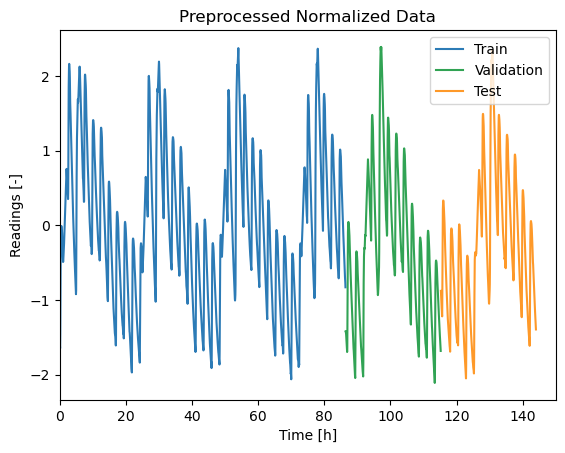

In [3]:
# Store data in np.arrays, convert time to hours and cut off data
time = df["Time"].to_numpy()
time = time / 3600
readings = df["Partial Pressure CO2 Cabin"].to_numpy()
t_start = 24
time, readings = cut_off(time, readings, start_time=t_start)
readings = readings.reshape(-1,1)

# 1.) Interpolate data (this should be done in pandas?)
t_max = 7*24 - t_start
t_step = 0.05 # [h]
kind = "linear"
uniform_time, readings_intp = interpolate(readings, time, t_max=t_max, t_step=t_step, kind=kind)
readings = readings_intp.reshape(-1,1)
uniform_time = uniform_time.reshape(-1,1)

print("--- Interpolation done ---")
print( "  Type:", kind)
print(f"  Time step: {t_step} hours")
print( "  Total time steps:", uniform_time.shape[0])
print("\n")

# 2.) Split data into Train, Test, Validation
# Maybe split based on days, not percentages
t_split = 100 #[h]
r_train = 0.6
r_test = 0.2
r_validation = r_test

idx_train = int(np.ceil(r_train*uniform_time.shape[0]))
idx_validation = int(np.ceil((1-r_validation)*uniform_time.shape[0]))

train_set = readings[:idx_train]
test_set = readings[idx_train:idx_validation]
validation_set = readings[idx_validation:]

t_train = uniform_time[:idx_train]
t_validation = uniform_time[idx_train:idx_validation]
t_test = uniform_time[idx_validation:]

# 3.) Normalize data 
scaler = StandardScaler()
scaler.fit(train_set)

train = normalize(train_set, scaler)
validation = normalize(validation_set, scaler)
test = normalize(test_set, scaler)

print("--- Normalization done ---")

# Validate preprocessing visually
plt.plot(t_train, train, label="Train", color="#2c7bb6")
plt.plot(t_validation, validation, label="Validation", color="#31a354")
plt.plot(t_test, test, label="Test", color="#fe9929")
plt.xlim(0, 150)
plt.xlabel("Time [h]")
plt.ylabel("Readings [-]")
plt.title("Preprocessed Normalized Data")
plt.legend(loc="upper right")

In [ ]:
# Create the training features X (here 1D sequenceuences) and Labels y (points for now)
t_in = 3        #2 hours [h]
t_out = 1     #30 minutes [h]

# calculate corresponding amount of time steps, i.e. number of lags 
t_steps_in = int(t_in / t_step)
t_steps_out = int(t_out / t_step)

"""
X_train, X_test: Train, Test features, i.e. an array of rolling windows of length t_in
y_train, y_test: Train, Test labels, i.e. an array of rolling windows of length t_out  
"""

X_train, y_train, t_X_train, t_y_train = create_sequences(train, t_train, t_steps_in, t_steps_out)
X_validation, y_validation, t_X_validation, t_y_validation = create_sequences(validation, t_validation, t_steps_in, t_steps_out)
X_test, y_test, t_X_test, t_y_test = create_sequences(test, t_test, t_steps_in, t_steps_out)
print("TRAINING SPLIT DONE\n")
print("--- Readings ---")
print("\nTrain features shape: ", np.shape(X_train))
print("Train labels shape: ", np.shape(y_train))
print("\nValidation features shape: ", np.shape(X_validation))
print("Validation labels shape: ", np.shape(y_validation))
print("\nTest features shape: ", np.shape(X_test))
print("Test labels shape: ", np.shape(y_test))
print("\n")
print("--- Times ---")
print("\nTrain feature times shape: ", np.shape(t_X_train))
print("Train label times shape: ", np.shape(t_y_train))
print("\nValidation feature times shape: ", np.shape(t_X_validation))
print("Validation label times shape: ", np.shape(t_y_validation))
print("\nTest feature times shape: ", np.shape(t_X_test))
print("Test label times shape: ", np.shape(t_y_test))

In [63]:
# Create a DataLoader
batch_size = 10 
dataset = Sequence_Dataset(X_train, y_train)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [ ]:
# Train the model
input_size = 1  # Number of input sequenceuences
hidden_size = 64  # Hidden Layers
num_layers = 2  # Number of LSTMs
output_size = t_steps_out # How many future points should be predicted

model = LSTMModel(input_size, hidden_size, num_layers, output_size)
model = train_model(model, data_loader, num_epochs=30, learning_rate=0.001)

In [14]:
# Save the model's state_dict and architecture
model_config = {
    'input_size': input_size,
    'hidden_size': hidden_size,
    'num_layers': num_layers,
    'output_size': output_size,
    'state_dict': model.state_dict()
}

torch.save(model_config, 'lstm_model.pth')

In [ ]:
# Load the model configuration
model_config = torch.load('lstm_model_with_config.pth')

# Reinitialize the model using saved architecture parameters
loaded_model = LSTMModel(
    input_size=model_config['input_size'],
    hidden_size=model_config['hidden_size'],
    num_layers=model_config['num_layers'],
    output_size=model_config['output_size']
)

# Load the saved state_dict
loaded_model.load_state_dict(model_config['state_dict'])

### Predict on validation set

In [ ]:
model.eval()

out_shape = y_validation.shape
inputs = torch.tensor(X_validation, dtype=torch.float32)

with torch.no_grad():
    predictions = model(inputs).unsqueeze(-1).numpy()


# Calculate metrics for each sequenceuence
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

num_sequenceuences = y_validation.shape[0]
mse_per_sequenceuence = []
rmse_per_sequenceuence = []
mae_per_sequenceuence = []
r2_per_sequenceuence = []

for i in range(num_sequenceuences):
    # Calculate metrics for the i-th sequenceuence
    mse = mean_squared_error(y_validation[i, :, 0], predictions[i, :, 0])
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_validation[i, :, 0], predictions[i, :, 0])
    r2 = r2_score(y_validation[i, :, 0], predictions[i, :, 0])

    # Append the results to the lists
    mse_per_sequenceuence.append(mse)
    rmse_per_sequenceuence.append(rmse)
    mae_per_sequenceuence.append(mae)
    r2_per_sequenceuence.append(r2)

# Aggregate the metrics
avg_mse = np.mean(mse_per_sequenceuence)
avg_rmse = np.mean(rmse_per_sequenceuence)
avg_mae = np.mean(mae_per_sequenceuence)

std_mse = np.std(mse_per_sequenceuence)
std_rmse = np.std(rmse_per_sequenceuence)
std_mae = np.std(mae_per_sequenceuence)

# Print the results
print("\nAggregated Metrics:")
print(f"  Average MSE: {avg_mse:.4f} (std: {std_mse:.4f})")
print(f"  Average RMSE: {avg_rmse:.4f} (std: {std_rmse:.4f})")
print(f"  Average MAE: {avg_mae:.4f} (std: {std_mae:.4f})")

# 4. Plot Histograms of All Metric Distributions in One Plot
plt.hist(rmse_per_sequenceuence, bins=20, alpha=0.5, label="RMSE")
plt.hist(mae_per_sequenceuence, bins=20, alpha=0.5, label="MAE")


plt.xlabel("Metric Value")
plt.ylabel("Frequency")
plt.title("Distribution of Metrics Across sequenceuences")
plt.legend()
plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.show()

In [ ]:
# Visualize predictions of validation set for a few sequences

num_sequenceuences_to_plot = 9
fig, axs = plt.subplots(3,3, sharex=True, sharey=True)
for i, ax in enumerate(axs.flatten()):
    r = np.random.randint(0, predictions.shape[0])
    t_start = np.round(t_y_validation[r, 0, 0], 1)
    t = np.arange(0, t_out, t_step) + t_step # startet es von 0 oder 0.05?
    
    ax.plot(t, y_validation[r, :, 0], label="True")
    ax.plot(t, predictions[r, :, 0], label="Predicted")
    ax.set_title(r"$t_0=$" + f"{t_start}")
    ax.set_xticks([0, 0.5, 1])
    ax.set_yticks([-2, 0, 2])

fig.legend(labels=["True", "Predicted"], loc="upper center", ncol=2)
fig.supxlabel("dt [h]")
fig.supylabel("Readings [-]")
fig.subplots_adjust(hspace=0.4, wspace=0.2)

In [ ]:
y_validation

### Predict on a selected sequence

In [ ]:
# Predict

s = 100
sequence = X_validation[s]
sequence_label = y_validation[s]
t_sequence = t_X_validation[s]
t_sequence_label = t_y_validation[s]

input_sequence = torch.tensor(sequence, dtype=torch.float32).unsqueeze(0)
true_sequence = torch.tensor(sequence_label, dtype=torch.float32).unsqueeze(0)

model.eval()
with torch.no_grad():
    predicted_sequence = model(input_sequence).numpy()

# Plot the results
t = t_sequence_label
pred = predicted_sequence.reshape(-1,1)

readings_normalized = np.concat((train, validation, test))
# append last value from time series to have a continous plot
index, _ = np.where(uniform_time == t_sequence_label[0]) 
t = np.concat((uniform_time[index-1], t_sequence_label))
pred = np.concat((readings_normalized[index-1], pred))

# define time limit
t_margin = 5
xlim_0 = t_sequence_label[0] - t_margin
xlim_end = t_sequence_label[-1] + t_margin

readings = scaler.inverse_transform(readings_normalized)
pred = scaler.inverse_transform(pred)
sequence = scaler.inverse_transform(sequence)

plt.figure()
plt.plot(uniform_time, readings, label="True series", color="#969696", linestyle="--")
plt.plot(t, pred, color="#7b3294", linestyle="-", label="LSTM prediction")
plt.plot(t_sequence, sequence, color="#a6dba0", linestyle="-", label="LSTM input sequence")
plt.title("LSTM Forecasting on Validation Set")
plt.xlabel("Time [h]")
plt.ylabel("Partial Pressure CO2 Cabin [Pa]")
plt.legend()
plt.xlim(xlim_0, xlim_end)
plt.show()


ARIMA

In [ ]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA

result = adfuller(train)
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")
if result[1] > 0.05:
    print("The time series is non-stationary (fail to reject the null hypothesis).")
else:
    print("The time series is stationary (reject the null hypothesis).")


In [20]:
# ARIMA sollte wie das LSTM trainiert werden! Auf variable window size und dann gesamt error

series = np.concat((train, X_validation[0:s].reshape(-1,1)), axis=0)

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Define SARIMA parameters
p, d, q = 4, 0, 3  # Non-seasonal components
P, D, Q, m = 2, 0, 1, 12  # Seasonal components (m = seasonality period)

# Fit the SARIMA model
arima_model = ARIMA(series, order=(p, d, q))
arima_model = arima_model.fit()


SARIMA: more computational powers for large data sets

In [ ]:
# Forecasting
forecast_time = t_out  # Number of future steps to forecast
forecast_steps = int(forecast_time / t_step)
forecast = arima_model.forecast(steps=forecast_steps)

# Plot results

t_margin = 2
xlim_0 = t_sequence_label[0] - t_margin
xlim_end = t_sequence_label[-1] + t_margin

plt.figure()
plt.plot(uniform_time, readings, label="True series", color="#969696", linestyle="--")
plt.plot(t_sequence, sequence, color="#c2a5cf", linestyle="-.", label="LSTM input sequence")
plt.plot(t, pred, color="#7b3294", linestyle="-", label="LSTM prediction")
plt.plot(t_sequence_label, denormalize(forecast.reshape(-1,1), scaler), label="ARIMA Forecast", color="#de2d26")
plt.title("LSTM Forecasting")
plt.xlabel("Time [h]")
plt.ylabel("Partial Pressure CO2 Cabin [Pa]")
plt.legend()
plt.xlim(xlim_0, xlim_end)
plt.show()

In [ ]:
denormalize(forecast.reshape(-1,1), scaler)
uniform_time[idx_train]

NEXT UP: 

- ~~Define window size in physical time~~ 

- Multivariate Time-series (Zeolite Cycles + (maybe) human CO2,VO2 or similar --> something that indicates the human rhythm for the model to learn)

- At least one more modell: ARIMA ?


EXTENSIONS UNLIMITED:

- Variable Window size
- UQ 
- Attention or Transformers
- Hyperparameter studies (Window sizes)
- 